Loading real dataset...
Extracting rPPG features...
Dataset shape: (36, 12)
Class distribution: Counter({np.int64(3): 13, np.int64(2): 10, np.int64(1): 10, np.int64(0): 3})

Training Model...

          FINAL METRICS             
Accuracy  : 0.5
F1 Macro  : 0.3542

Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1
           2       0.00      0.00      0.00         2
           3       0.75      0.75      0.75         4

    accuracy                           0.50         8
   macro avg       0.31      0.44      0.35         8
weighted avg       0.44      0.50      0.46         8



c:\Users\Nischay Sharma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Nischay Sharma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Nischay Sharma\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi


Cross Validation Results:
Mean Accuracy: 0.225
Mean F1 Macro: 0.1839


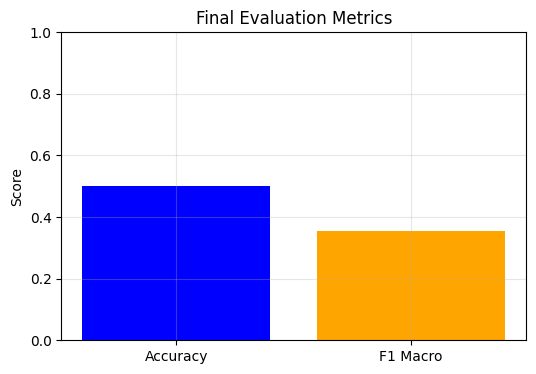

In [ ]:
import numpy as np
import os
from scipy.signal import butter, filtfilt, welch, find_peaks
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from collections import Counter
import matplotlib.pyplot as plt
import joblib

try:
    trapz = np.trapz
except AttributeError:
    trapz = np.trapezoid


def bandpass(signal, fs, low=0.7, high=4.0, order=3):
    nyq = 0.5 * fs
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, signal)


def extract_rppg_features(rppg, fs=30):
    if len(rppg) < fs:
        return np.zeros(12)

    rppg = bandpass(rppg, fs)
    rppg = (rppg - np.mean(rppg)) / (np.std(rppg) + 1e-6)

    peaks, _ = find_peaks(rppg, distance=int(fs * 0.5))

    if len(peaks) < 2:
        rr_intervals = np.array([1])
    else:
        rr_intervals = np.diff(peaks) / fs

    hr = 60 / (np.mean(rr_intervals) + 1e-6)
    hrv_sdnn = np.std(rr_intervals)

    signal_power = np.var(rppg)
    noise_power = np.var(np.diff(rppg)) + 1e-6
    sqi = signal_power / noise_power

    freqs, psd = welch(rppg, fs=fs, nperseg=min(256, len(rppg)))
    total_power = trapz(psd, freqs)

    return np.array([
        hr,
        hrv_sdnn,
        sqi,
        total_power,
        np.mean(rppg),
        np.std(rppg),
        np.max(rppg),
        np.min(rppg),
        len(peaks),
        np.percentile(rppg, 25),
        np.percentile(rppg, 50),
        np.percentile(rppg, 75)
    ])


def build_rppg_feature_matrix(rppg_signals, fs=30):
    feats = [extract_rppg_features(sig, fs) for sig in rppg_signals]
    return np.array(feats)


X_rppg_raw = []
y = []

DATA_FILE = "rppg_waveforms.npy"

if os.path.exists(DATA_FILE):
    data_container = np.load(DATA_FILE, allow_pickle=True)

    if data_container.shape == ():
        data_dict = data_container.item()
    else:
        data_dict = data_container

    for video_name, content in data_dict.items():
        X_rppg_raw.append(content['rppg'])
        y.append(content['label'])

    X_rppg_raw = np.array(X_rppg_raw, dtype=object)
    y = np.array(y)
    y_discrete = np.round(y * 3).astype(int)

else:
    N = 40
    X_rppg_raw = [np.random.randn(300) for _ in range(N)]
    y_discrete = np.random.randint(0, 3, N)


X = build_rppg_feature_matrix(X_rppg_raw)
X = np.nan_to_num(X)

print("Dataset shape:", X.shape)
print("Class distribution:", Counter(y_discrete))


X_train, X_test, y_train, y_test = train_test_split(
    X, y_discrete, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, "rppg_scaler.pkl")

clf1 = RandomForestClassifier(
    n_estimators=150,
    max_depth=7,
    class_weight='balanced',
    random_state=42
)

clf2 = GradientBoostingClassifier(n_estimators=100)

model = VotingClassifier(
    estimators=[('rf', clf1), ('gb', clf2)],
    voting='soft'
)

model.fit(X_train, y_train)

joblib.dump(model, "final_rppg_model.pkl")

pred = model.predict(X_test)

acc = accuracy_score(y_test, pred)
f1_macro = f1_score(y_test, pred, average='macro')

print("FINAL METRICS")
print("Accuracy  :", round(acc, 4))
print("F1 Macro  :", round(f1_macro, 4))
print(classification_report(y_test, pred))

cv_acc = cross_val_score(model, X, y_discrete, cv=5, scoring='accuracy')
cv_f1 = cross_val_score(model, X, y_discrete, cv=5, scoring='f1_macro')

print("Mean Accuracy:", round(cv_acc.mean(), 4))
print("Mean F1 Macro:", round(cv_f1.mean(), 4))

plt.figure(figsize=(6, 4))
plt.bar(["Accuracy", "F1 Macro"], [acc, f1_macro])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.grid(alpha=0.3)
plt.show()


In [2]:
import numpy as np
from scipy.signal import butter, filtfilt, welch, find_peaks

def extract_physio_features(rppg_signal, fs=30):
    """
    Extracts HR, HRV, SQI, and Bandpower features from a raw rPPG signal.
    
    Args:
        rppg_signal (np.array): 1D array of the rPPG waveform.
        fs (int): Sampling rate (Frames Per Second), default 30.
        
    Returns:
        dict: Dictionary containing HR, HRV, SQI, and LF/HF Ratio.
    """
    
    # --- 1. PREPROCESSING 
    def butter_bandpass(sig, lowcut, highcut, fs, order=3):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, sig)

    # Clean signal
    clean_rppg = butter_bandpass(rppg_signal, 0.7, 4.0, fs)
    
    # Normalize (Z-score) to handle amplitude variations
    clean_rppg = (clean_rppg - np.mean(clean_rppg)) / (np.std(clean_rppg) + 1e-6)

    # --- 2. HR PROXY (Heart Rate) ---

    peaks, _ = find_peaks(clean_rppg, distance=int(fs * 0.4))
    
    if len(peaks) < 2:
        hr = 0
        sdnn = 0
        rmssd = 0
    else:
        rr_intervals = np.diff(peaks) / fs
        
        hr = 60 / (np.mean(rr_intervals) + 1e-6)

        # --- 3. VARIABILITY PROXY (HRV) ---
        sdnn = np.std(rr_intervals)
        
        rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

    # --- 4. SQI (Signal Quality Index) ---
    signal_power = np.var(clean_rppg)
    noise_power = np.var(np.diff(clean_rppg))
    sqi = signal_power / (noise_power + 1e-6)

    # --- 5. BANDPOWER FEATURES (LF/HF Ratio) ---
    nperseg = min(256, len(clean_rppg))
    freqs, psd = welch(clean_rppg, fs=fs, nperseg=nperseg)

    # Define bands: 
    # LF (Low Freq): 0.04 - 0.15 Hz (Sympathetic/Stress)
    # HF (High Freq): 0.15 - 0.4 Hz (Parasympathetic/Relaxation)
    lf_band = (0.04, 0.15)
    hf_band = (0.15, 0.4)

    # Integrate area under the curve for these bands

    try:
        trapz = np.trapz
    except AttributeError:
        trapz = np.trapezoid

    lf_mask = (freqs >= lf_band[0]) & (freqs <= lf_band[1])
    hf_mask = (freqs >= hf_band[0]) & (freqs <= hf_band[1])

    lf_power = trapz(psd[lf_mask], freqs[lf_mask]) if np.sum(lf_mask) > 0 else 0
    hf_power = trapz(psd[hf_mask], freqs[hf_mask]) if np.sum(hf_mask) > 0 else 0
    
    # LF/HF Ratio (High = Stress/Focus, Low = Relaxation)
    lf_hf_ratio = lf_power / (hf_power + 1e-6)

    return {
        "HR_Proxy": round(hr, 2),
        "HRV_SDNN": round(sdnn, 4),
        "HRV_RMSSD": round(rmssd, 4),
        "SQI": round(sqi, 2),
        "LF_HF_Ratio": round(lf_hf_ratio, 2)
    }

# --- EXAMPLE USAGE ---
if __name__ == "__main__":
    # Simulate a dummy rPPG signal (300 frames = 10 seconds at 30 FPS)
    # It combines a heartbeat sine wave (1.2 Hz = 72 BPM) with some noise
    t = np.linspace(0, 10, 300)
    dummy_signal = np.sin(2 * np.pi * 1.2 * t) + 0.2 * np.random.normal(size=300)

    features = extract_physio_features(dummy_signal, fs=30)
    
    print("--- Extracted Physiological Features ---")
    for key, value in features.items():
        print(f"{key}: {value}")

--- Extracted Physiological Features ---
HR_Proxy: 72.0
HRV_SDNN: 0.0402
HRV_RMSSD: 0.0745
SQI: 15.4
LF_HF_Ratio: 0.0
